## Basic Initial Strategy Setup:
1. Perform Long Small Cap-Short Large Cap beta neutral 3M backtest strategy as benchmark (although it will be most likely pretty shitty)
2. Then perform a Long Small Cap-Short Large Cap- Long Weighted Mag 7 beta neutral strategy (In order to not have the effects of the MegaCaps)

In [2]:
import pandas as pd
import yfinance as yf 
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [28]:
# --- Parameters ---
start_date = "2024-03-08"  # Rebalance day
end_date   = "2024-09-09"  #  6 Months later
sp500_ticker = "^GSPC"     # S&P 500 Index
sp600_ticker = "^SP600"    # S&P 600 Small Cap

# --- 1. Download Price Data ---
sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date)["Adj Close"]
sp600_data = yf.download(sp600_ticker, start=start_date, end=end_date)["Adj Close"]

# --- 2. Calculate Daily Returns ---
sp500_returns = sp500_data.pct_change().dropna()
sp600_returns = sp600_data.pct_change().dropna()

# Align the returns DataFrames (in case of mismatched trading days)
returns_df = pd.DataFrame({
    'SP500': sp500_returns,
    'SP600': sp600_returns
}).dropna()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [29]:
# --- 3. Linear Regression to Estimate Beta ---
X = sm.add_constant(returns_df['SP500'])  # Add intercept
y = returns_df['SP600']
model = sm.OLS(y, X).fit()
beta = model.params['SP500']

print("Regression Results:")
print(model.summary())
print(f"\nEstimated Beta: {beta:.4f}\n")

Regression Results:
                            OLS Regression Results                            
Dep. Variable:                  SP600   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     115.3
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           2.22e-19
Time:                        16:29:42   Log-Likelihood:                 412.73
No. Observations:                 125   AIC:                            -821.5
Df Residuals:                     123   BIC:                            -815.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001

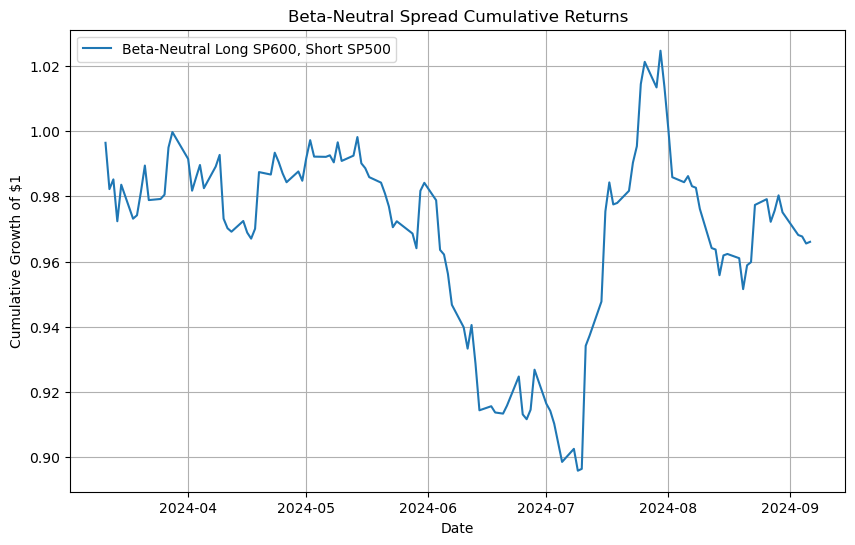

In [ ]:
# --- 4. Construct Beta-Neutral Strategy Returns ---
# Strategy return on each day = SP600_return - beta * SP500_return
strategy_returns = returns_df['SP600'] - (beta) * returns_df['SP500'] 

# --- 5. Backtest: Cumulative Performance of the Spread ---
# Assuming $1 initial capital in the spread
cumulative_performance = (1 + strategy_returns).cumprod()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(cumulative_performance, label='Beta-Neutral Long SP600, Short SP500')
plt.title('Beta-Neutral Spread Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth of $1')
plt.legend()
plt.grid(True)
plt.show()

## Observations
1. Dogshit strategy (obviously because of the amazing performance of Mag7)
2. Lets try now "Hedging" the effects of Mag7

In [38]:
# --- 1) Read in Mag7 file and set up date index ---
mag7_df = pd.read_csv("SP500_returns_output.csv", usecols=["Dates","Mag7_Ret Cap weighted"])
# Convert date column to DateTime
mag7_df["Dates"] = pd.to_datetime(mag7_df["Dates"])
# Make "Dates" the index
mag7_df.set_index("Dates", inplace=True)
# Rename the return column
mag7_df.rename(columns={"Mag7_Ret Cap weighted": "Mag7"}, inplace=True)

# Convert mag7_df (1-column DataFrame) to a Series
mag7_series = mag7_df["Mag7"]
# Optionally confirm name
mag7_series.name = "Mag7"

# --- 2) Align / Merge All Returns by Date ---
returns_df = pd.concat(
    [
        sp600_returns.rename("SP600"),  # already a Series
        sp500_returns.rename("SP500"),  # already a Series
        mag7_series                     # now a Series too
    ],
    axis=1
).dropna()

Multi-Factor Regression Results:
                            OLS Regression Results                            
Dep. Variable:                  SP600   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     138.9
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           3.61e-32
Time:                        16:39:58   Log-Likelihood:                 445.58
No. Observations:                 125   AIC:                            -885.2
Df Residuals:                     122   BIC:                            -876.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.00

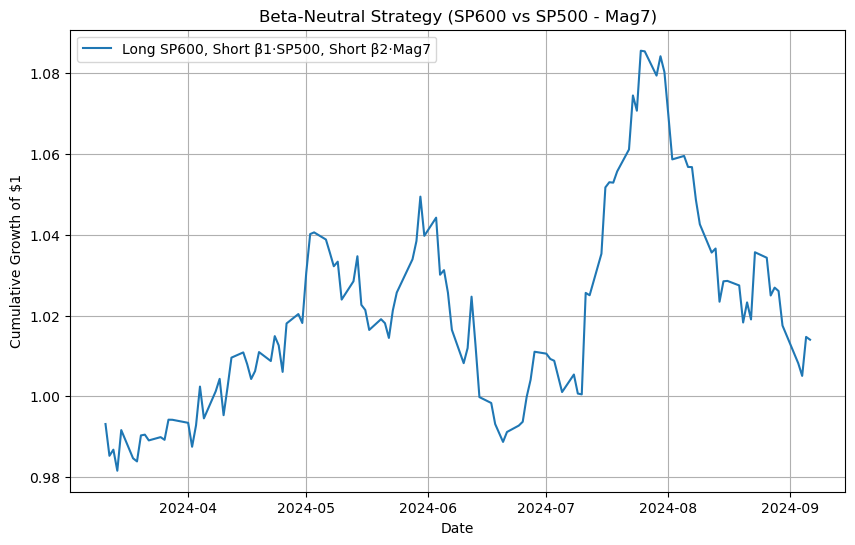

In [39]:
# -----------------------------------------
# 2) Multi-Factor Regression:
#    SP600(t) = α + β1 * SP500(t) + β2 * Mag7(t) + ε(t)
# -----------------------------------------
X = sm.add_constant(returns_df[['SP500', 'Mag7']])  # Add intercept
y = returns_df['SP600']

model = sm.OLS(y, X).fit()
beta_sp500 = model.params['SP500']
beta_mag7  = model.params['Mag7']

print("Multi-Factor Regression Results:")
print(model.summary())
# -----------------------------------------
# 3) Construct a Market-Neutral Strategy
#    Strategy Return = SP600 - β1 * SP500 - β2 * Mag7
# -----------------------------------------
strategy_returns = returns_df['SP600'] \
                   - beta_sp500 * returns_df['SP500'] \
                   - beta_mag7  * returns_df['Mag7']

# -----------------------------------------
# 4) Backtest: Calculate Cumulative Performance
# -----------------------------------------
cumulative_performance = (1 + strategy_returns).cumprod()

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(cumulative_performance, label='Long SP600, Short β1·SP500, Short β2·Mag7')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth of $1')
plt.title('Beta-Neutral Strategy (SP600 vs SP500 - Mag7)')
plt.legend()
plt.grid(True)
plt.show()